# Food Delivery Operations Exploratory Data Analysis

In [1]:
# Importing Dataset from Kaggle

import kagglehub
Zomato_dataset = kagglehub.dataset_download('saurabhbadole/zomato-delivery-operations-analytics-dataset')

print('Data source import complete.')

Data source import complete.


In [5]:
!pip install geopy
!pip install gmplot

In [6]:
# Importing all the required libraries

import numpy as np
import pandas as pd
import os
import gc
from datetime import datetime
from datetime import date as dt
import geopy.distance
from geopy.geocoders import *
import gmplot

import warnings
warnings.simplefilter(action='ignore')

#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sborn

#variables
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
TIME_FORMAT = '%H:%M'
DATE_FORMAT = '%d-%m-%Y'

In [7]:
# helper function/s

# calculate time difference
def get_timediff(t1:str, t2:str):
    
    '''
    get time difference between 2 time strings
    note: assumption is that t2 is always greater !
    '''
    try:
        t1 = datetime.strptime(t1, TIME_FORMAT)
        t2 = datetime.strptime(t2, TIME_FORMAT)
        if t2 > t1:
            subtractedTime = t2 - t1
            return int(subtractedTime.total_seconds() / 60)  # conver to mins
        else:
            return None
    except:
        return None
    

# calculate distance from geo-coordinates
def get_distance(rlat:float, rlon:float, dlat:float, dlon:float):
    
    '''
    get the distance (km) between 2 geo - coordinates
    note: the argument order does not change (restaurant > delivert loc.)
    '''
    # restaurant co-ordinates
    res_coords = (abs(rlat), abs(rlon))
    
    # delivery location co-ordinates
    dl_coords = (abs(dlat), abs(dlon))
    
    # get the distance
    try:
        dist = geopy.distance.geodesic(res_coords, dl_coords).km
        return round(dist,2)             # round to nearest 2 decimals
    except:
        return None

In [14]:
#import csv file as a pandas data frame along with date parsing for Order_date (optimization)

csv_file_path = os.path.join(Zomato_dataset, 'Zomato Dataset.csv')
dateparse = lambda x: datetime.strptime(x, DATE_FORMAT)
df = pd.read_csv(csv_file_path, parse_dates=['Order_Date'], date_parser=dateparse)

#drop rows with null values
df.dropna(inplace=True)

# renaming columns with spaces (to avoid data type errors)
df.rename(columns={'Time_taken (min)':'Time_taken_min'}, inplace=True)

# formatting column names -- optional
df.columns = [c.lower() for c in df.columns]
          
# sorting data for visualization
df.sort_values(by=['order_date'],inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_min
0,0xc102,KOLRES19DEL02,27.0,4.4,-22.549100,88.400467,22.569100,88.420467,2022-02-11,11:55,12:10,Sunny,High,0,Snack,motorcycle,2.0,No,Metropolitian,49
1,0xc47e,ALHRES07DEL01,22.0,4.1,25.449659,81.839744,25.459659,81.849744,2022-02-11,09:45,09:50,Windy,Low,0,Meal,motorcycle,0.0,No,Metropolitian,16
2,0xcff9,AURGRES13DEL02,24.0,5.0,19.880256,75.323503,19.930256,75.373503,2022-02-11,17:45,17:50,Cloudy,Medium,1,Buffet,motorcycle,1.0,No,Metropolitian,15
3,0xdef0,AURGRES12DEL01,34.0,4.8,19.879631,75.323403,19.919631,75.363403,2022-02-11,16:15,16:20,Windy,Medium,1,Snack,motorcycle,1.0,No,Metropolitian,34
4,0xbfcc,LUDHRES010DEL01,29.0,4.7,30.892860,75.822199,30.932860,75.862199,2022-02-11,15:40,15:50,Fog,Medium,2,Drinks,electric_scooter,0.0,No,Metropolitian,17


In [15]:
# de-duplication criteria#1 columns 
dup_c1 = ['delivery_person_id'
       ,'delivery_person_age'
       #,'delivery_location_latitude'
       #,'delivery_location_longitude'
       ,'order_date'
       ,'time_orderd']

# de-duplicate the dataset (keep = None)
df = df[~df.duplicated(subset=dup_c1, keep=False)]

### convert age into INT ###  -- optional
df['delivery_person_age'] = df['delivery_person_age'].astype(np.int64)

### derive pickup time(mins) = time_ordered - time_order_picked ###
time_diff = []

for idx, row in df.iterrows():
    td = get_timediff(row['time_orderd'],row['time_order_picked'])
    time_diff.append(td)

df['pickup_time_min'] = time_diff
df = df[~df['pickup_time_min'].isnull()]
df['pickup_time_min'] = df['pickup_time_min'].astype(np.int64)

# ### Cleaning up utilized columns in order to keep data table limited
# unwanted_cols = ['time_orderd','time_order_picked']
# df.drop(unwanted_cols, inplace=True, axis=1)

# ### derive distance between restaurant & delivery location ###
# dist = []

# for idx, row in df.iterrows():
#     d = get_distance(row['restaurant_latitude'], row['restaurant_longitude'], row['delivery_location_latitude'], row['delivery_location_longitude'])
#     dist.append(d)
    
# df['delivery_dist_km'] = dist

# unwanted_cols = ['restaurant_latitude','restaurant_longitude', 'delivery_location_latitude', 'delivery_location_longitude']
# df.drop(unwanted_cols, inplace=True, axis=1)

# df.reset_index(drop=True, inplace=True)

print(f"Data Shape: {df.shape}\n\n")

Data Shape: (33393, 21)


<class 'pandas.core.frame.DataFrame'>
Index: 33393 entries, 0 to 41358
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           33393 non-null  object        
 1   delivery_person_id           33393 non-null  object        
 2   delivery_person_age          33393 non-null  int64         
 3   delivery_person_ratings      33393 non-null  float64       
 4   restaurant_latitude          33393 non-null  float64       
 5   restaurant_longitude         33393 non-null  float64       
 6   delivery_location_latitude   33393 non-null  float64       
 7   delivery_location_longitude  33393 non-null  float64       
 8   order_date                   33393 non-null  datetime64[ns]
 9   time_orderd                  33393 non-null  object        
 10  time_order_picked            33393 non-null  object        
 11  weather_conditions  

In [17]:
# Step 1: Create a unique DataFrame of restaurant locations
unique_restaurants = df[['restaurant_latitude', 'restaurant_longitude']].drop_duplicates().reset_index(drop=True)

# Step 2: Assign a unique ID
unique_restaurants['restaurant_id'] = range(1, len(unique_restaurants) + 1)

# Step 3: Merge back to original DataFrame
df = df.merge(unique_restaurants, on=['restaurant_latitude', 'restaurant_longitude'], how='left')

df.info()

# Group by restaurant_id and count number of orders
df1 = df.groupby(['restaurant_id', 'restaurant_latitude', 'restaurant_longitude']).agg(
    total_orders=('restaurant_id', 'count')
).reset_index()

# All restaurants in Mumbai
df2 = df1[(df1['restaurant_latitude'] >= 10)].reset_index(drop=True)

# Preview
print(df2.head())
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33393 entries, 0 to 33392
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           33393 non-null  object        
 1   delivery_person_id           33393 non-null  object        
 2   delivery_person_age          33393 non-null  int64         
 3   delivery_person_ratings      33393 non-null  float64       
 4   restaurant_latitude          33393 non-null  float64       
 5   restaurant_longitude         33393 non-null  float64       
 6   delivery_location_latitude   33393 non-null  float64       
 7   delivery_location_longitude  33393 non-null  float64       
 8   order_date                   33393 non-null  datetime64[ns]
 9   time_orderd                  33393 non-null  object        
 10  time_order_picked            33393 non-null  object        
 11  weather_conditions           33393 non-nu

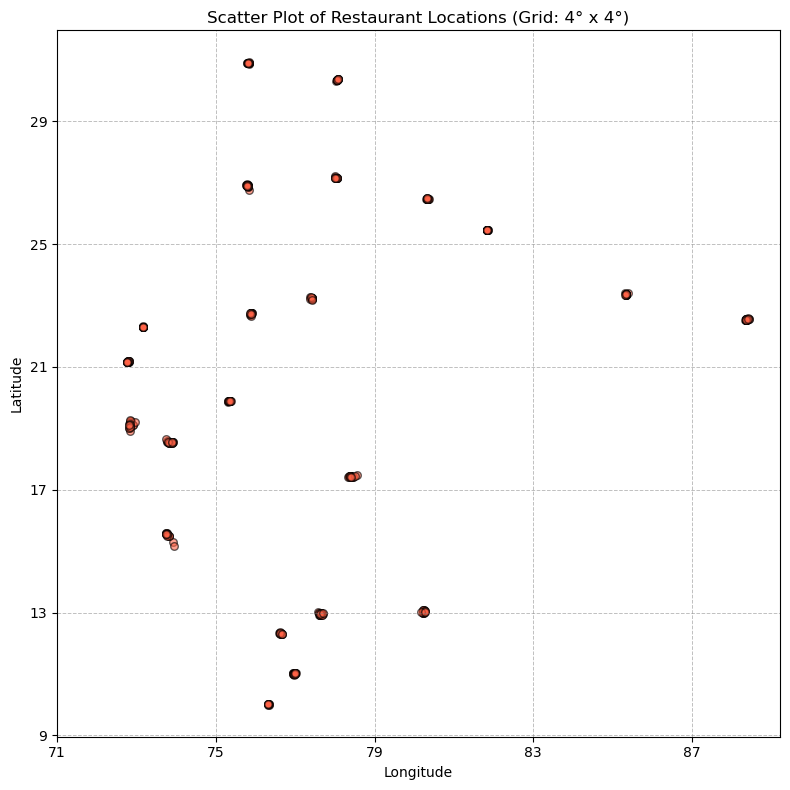

In [18]:
# Create the figure
plt.figure(figsize=(8, 8))

# Scatter plot of restaurant locations
plt.scatter(df2['restaurant_longitude'], df2['restaurant_latitude'],
            alpha=0.6, edgecolor='black', color='tomato', s=30)

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Restaurant Locations (Grid: 4° x 4°)')

# Define grid spacing
lon_min, lon_max = df2['restaurant_longitude'].min(), df2['restaurant_longitude'].max()
lat_min, lat_max = df2['restaurant_latitude'].min(), df2['restaurant_latitude'].max()

# Set ticks for every 4 degrees
plt.xticks(range(int(lon_min)-1, int(lon_max)+2, 4))
plt.yticks(range(int(lat_min)-1, int(lat_max)+2, 4))

# Add vertical and horizontal gridlines at every 4 degrees
for x in range(int(lon_min)-1, int(lon_max)+2, 4):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
for y in range(int(lat_min)-1, int(lat_max)+2, 4):
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

# Add custom grid
plt.grid(False)
plt.tight_layout()
plt.show()
